## MOVIELENS SMALL
I'm going to take a look at the MovieLens dataset. Although not the full 26M version (my poor GTX1060 is nowhere near powerful enough to do well on that), this 100k sample long dataset should provide a good enough basis to build some meaningful analysis from.

### Preparation
#### Standard imports and global variables

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from fastai.learner import *
from fastai.column_data import *

In [2]:
path='data/MovieLens/'
fname_ratings = 'ratings.csv'
fname_movies = 'movies.csv'

#### Loading the dataset
Lets read in the data and go over how it looks like. There are three .csv's provided with the data: ratings.csv, movies.csv, and tags.csv. I feel tags.csv is too arbitrary and sparse for any meaningful analysis, and will stick with just movies.csv and ratings.csv. The former contains data on the movie title and genres, while the latter has each user's ratings on specific movies.

In [3]:
ratings = pd.read_csv(path+fname_ratings)
movies = pd.read_csv(path+fname_movies)

Quick look on what these DataFrames looks like:

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.shape, movies.shape

((100004, 4), (9125, 3))

### Analyzing the data
So we want to see how the data looks like. My guess is ratings are on a 1-5 scale with 0.5 breakpoints. Another theory is that certain genres will have better ratings than others, e.g. dramas vs. comedies.

#### Ratings distribution
Starting with the easy part, lets check whether ratings are indeed from 1 to 5.

In [7]:
np.sort(ratings['rating'].unique())

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

My hunch was correct. This should help make things easier than a 1-10, 0.1 breakpoint scale. But what about the distribution? Does it behave like a normal distribution?

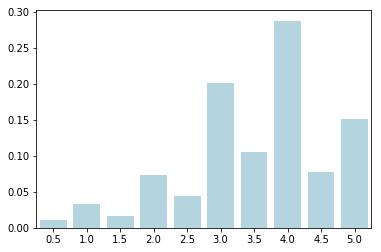

In [8]:
# Gets the frequency counts for each rating
counts = ratings['rating'].value_counts(normalize=True)
x = counts.index.values
y = counts.values
# Plots the distribution
sns.barplot(x, y, color="lightblue")

Obviously this doesn't look like a normal distribution at all. The ratings are heavily skewed to the right, indicating that users are more lenient when reviewing movies. From a personal standpoint, this makes sense. I never give 1 star ratings to bad movies, usually 2 to 3 stars, but wouldn't hesitate to give 5 stars to cinematic masterpieces like LOTR or La La Land. Then again, someone else might rate other movies on a different scale. This subjectivity could be a problem when building our model.

#### Genre biasedness
Next, I want to take a look at whether different genres have different ratings. Some data manipulation needs to be done here in order to get started. The plan is to create a list of different genres, then find the average rating of each movie and group them by genre.

In [9]:
# Splitting the genres strings into a Pandas DataFrame
gen = movies['genres'].str.split('|', expand=True)
genres = []
# Looping over each column and adding them to the list
for col in gen.columns:
    genres.extend(gen[col].unique())
# Keeping unique genres
genres = set(genres)
# Dropping the 'None' and '(no genres listed)' entries
genres.remove(None)
genres.remove('(no genres listed)')
genres, len(genres)

({'Action',
  'Adventure',
  'Animation',
  'Children',
  'Comedy',
  'Crime',
  'Documentary',
  'Drama',
  'Fantasy',
  'Film-Noir',
  'Horror',
  'IMAX',
  'Musical',
  'Mystery',
  'Romance',
  'Sci-Fi',
  'Thriller',
  'War',
  'Western'},
 19)

We end up with 19 different movie genres. Now we have to group the ratings by genre. It's worth noting that IMAX is in fact a genre now..

In [10]:
# Declaring new DataFrame grouping ratings by genre
ratings_by_genre = pd.DataFrame(index=movies.index.values,
                                columns=genres)
# crude for-loop to group them
for index, row in movies.iterrows():
    avgRating = ratings[ratings['movieId'] == row['movieId']]['rating'].mean()
    for genre in genres:
        if genre in row['genres']:
            ratings_by_genre.iloc[index][genre] = avgRating

As a sanity check, I'll go over a couple of the movies and make sure the averages are correct. Let's just do Toy Story and Jason Bourne.

In [11]:
toy_story = ratings_by_genre.iloc[0].max()
jason_bourne = ratings_by_genre.iloc[9101].max()
toy_story_orig = ratings[ratings['movieId'] == 1]['rating'].mean()
jason_bourne_orig = ratings[ratings['movieId'] == 160438]['rating'].mean()

toy_story == toy_story_orig, jason_bourne == jason_bourne_orig

(True, True)

Everything checks out so far. Lets see if users rate different genres differently.

In [12]:
averagesByGenre = ratings_by_genre.mean(axis=0)
averagesByGenre

Film-Noir      3.669072
Animation      3.418974
War            3.534021
Adventure      3.229862
Crime          3.301617
Mystery        3.383182
Fantasy        3.183827
Horror         2.991933
Drama          3.447417
Musical        3.334025
IMAX           3.059028
Thriller       3.183073
Sci-Fi         3.167052
Romance        3.344588
Comedy         3.190353
Children       3.138675
Documentary    3.686744
Action         3.090863
Western        3.421001
dtype: float64

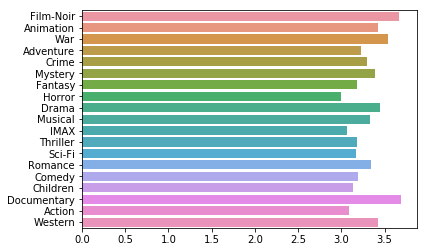

In [13]:
sns.barplot(averagesByGenre,
            averagesByGenre.index,
            orient="h")

Doesn't really look like there's a significant different between genres. That's one aspect of biasedness out of the equation.

### Collaborative filtering
#### Initializing the model
So let's start by declaring the learner and initializing it. I'm borrowing the CollabFilterDataset method from fast.ai's library as well as its corresponding get_learner() method. CollabFilterDataset is a pre-built collaborative filtering learner that builds its own matrix from a 2D dataset, which is what we have.

In [14]:
cf_data = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
# initializing parameters
val_idxs = get_cv_idxs(ratings.shape[0])
n_factors = 25
batchSize = 256
# initializing the learner to use an Adam optimization algorithm
learner = cf_data.get_learner(n_factors,
                             val_idxs,
                             batchSize,
                             opt_fn=optim.Adam)

The package also comes with a nifty method to find the optimal learning rate. It is done by plotting the learning_rate against loss and using the 'elbow' point for the learning rate. This ensures loss convergence without sacrificing processing time.

In [15]:
learner.lr_find()

epoch      trn_loss   val_loss                                                 
    0      5.388362   6.456549  



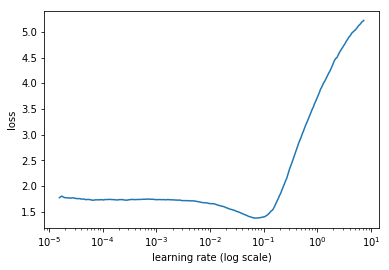

In [16]:
learner.sched.plot()

So our learning rate should definitely be before 1e-1. Major overfitting happens beyond that point. It should also ideally be after 1e-2 just so it doesn't take excessively long to converge, but let's just err on the side of caution and use 0.01.

In [17]:
lr = 0.01
wd = 1e-4    # this is the L2 regularization parameter. We want the weights to be reasonably well behaved.
learner.fit(lr, 3, wds=wd, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                 
    0      0.82684    0.799269  
    1      0.669458   0.776689                                                 
    2      0.680911   0.768911                                                 
    3      0.506421   0.772163                                                 
    4      0.363436   0.774762                                                 
    5      0.288085   0.776737                                                 
    6      0.513622   0.828444                                                 
    7      0.428942   0.814725                                                 
    8      0.378639   0.820188                                                 
    9      0.327657   0.822594                                                 
    10     0.284032   0.824967                                                 
    11     0.241821   0.827353                                                 
    12 

[array([0.82875])]

We used an approach called annealing with restarts to help reduce the chance of local minima as well. Essentially, we slowly reduce the learning rate at each iteration and reset it to its original value after each epoch. We also double the epochs per reset each time a reset occurs to help convergence. The plot below shows how the learning rate changes over time.

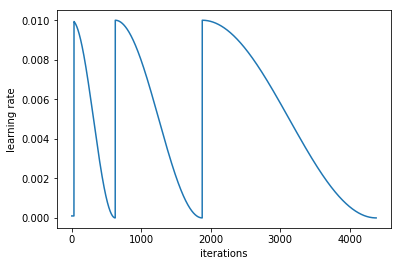

In [18]:
learner.sched.plot_lr()

The learner is also clearly overfitting starting from epoch 4. Let's try reinitializing the learner and fitting to just 4 epochs, then predicting. I'm also going to up the learning rate a little just to make sure it converges

In [19]:
learner = cf_data.get_learner(n_factors,
                             val_idxs,
                             batchSize,
                             opt_fn=optim.Adam)
lr = 0.015
learner.fit(lr, 2, wds=wd, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss                                                 
    0      0.815592   0.820051  
    1      0.739584   0.774074                                                 
    2      0.525509   0.763791                                                 
    3      0.334223   0.767147                                                 



[array([0.76715])]

Looking good. Now it's time to try predicting. I'll compare the predictions with the validation set.

C:\Users\Bryan\AppData\Local\conda\conda\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


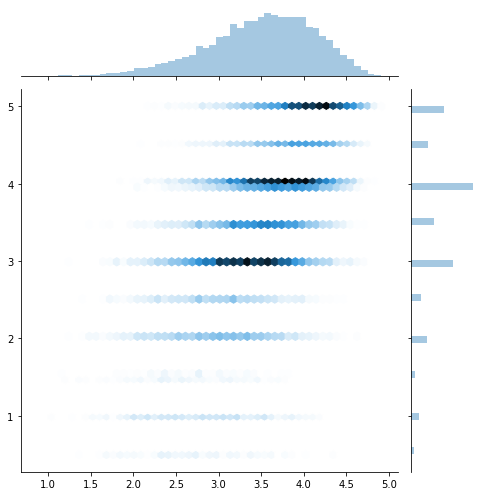

In [20]:
preds = learner.predict()
actuals = learner.data.val_y
sns.jointplot(preds, actuals, kind="hex", stat_func=None, size=7)

There is indeed a positive correlation between predictions and actuals. The hex plot gives a good idea on the learner's accuracy. It's actually pretty good at predicting user ratings to within 0.5 difference.

### Model Analysis
#### Layers
The deep learner makes use of embedded matrices to help the model identify traits possessed by movies. For example, dialogue heavy vs. little dialogue, or simply genre type. These take on a numerical value represented by the embeddings, as a spectrum representing the intensity of said trait. I'll start by looking at the embeddings and try to make sense of them by comparing movies on each end of these spectrums.

In [21]:
model = learner.model
model

EmbeddingDotBias(
  (u): Embedding(671, 25)
  (i): Embedding(9066, 25)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

#### Biases
The fast.ai documentation has these layers designated as u for users and i for items. These are the weights per user/item used to define the 25 traits identified by the model. Meanwhile, ub and ib are the biases for each of these entries, much like the b value in a linear y=ax+b curve. In the context of movies, which are the items in this model, ib's rankings could be a good representation of the overall userbase's sentiment towards movies. Let's take a look at the top and bottom 10 movies based on these biases. For simplicity's sake, I'm also going to narrow my view to the 1000 movies with the most number of ratings.

In [22]:
# initializing a dict for easy lookup in the future
movieTitles = movies.set_index('movieId')['title'].to_dict()
# grouping movies by number of ratings and keeping the top 1000
moviesWithCounts = ratings.groupby('movieId')['rating'].count()
topThousandMovies = moviesWithCounts.sort_values(ascending=False).index.values[:1000]
# getting indices of top 1000 movies corresponding to index in @movies
topMoviesIndices = np.array([cf_data.item2idx[o] for o in topThousandMovies])

In [23]:
movieBiases = to_np(model.ib(V(topMoviesIndices)))
movieBiases = [(b[0], movieTitles[i]) for i,b in zip(topThousandMovies, movieBiases)]

Okay now let's go over the 10 highest and lowest biases:
#### Top 10

In [24]:
sorted(movieBiases, reverse=True)[:10]

[(1.2285656, 'Shawshank Redemption, The (1994)'),
 (0.9559595, 'Usual Suspects, The (1995)'),
 (0.93635684, 'Godfather, The (1972)'),
 (0.8505829, '12 Angry Men (1957)'),
 (0.8339518, "Schindler's List (1993)"),
 (0.8114828, 'Stand by Me (1986)'),
 (0.8095997, 'Princess Bride, The (1987)'),
 (0.8088812, 'Silence of the Lambs, The (1991)'),
 (0.787944, 'Godfather: Part II, The (1974)'),
 (0.7833007, 'Fargo (1996)')]

#### Bottom 10

In [25]:
sorted(movieBiases)[:10]

[(-0.7120163, 'Wild Wild West (1999)'),
 (-0.7052543, 'Anaconda (1997)'),
 (-0.5836874, 'Congo (1995)'),
 (-0.57347834, 'Godzilla (1998)'),
 (-0.55380976, 'Batman & Robin (1997)'),
 (-0.534787, 'Flintstones, The (1994)'),
 (-0.46991667, 'Judge Dredd (1995)'),
 (-0.4661855, 'Home Alone 2: Lost in New York (1992)'),
 (-0.45306474, 'Lost in Space (1998)'),
 (-0.44899797, 'Hollow Man (2000)')]

Looks about right. I'd certainly rank Shawshank Redemption and Godfather in the top 10 movies of all time. Similarly, I wouldn't want to watch Bat-nipples again.

#### Embeddings
Now we'll check out what's happening with the embeddings themselves. Remember, these are the traits the model extracted from the data that it believes most allows it to properly assign ratings.

In [26]:
movie_embeddings = to_np(model.i(V(topMoviesIndices)))
movie_embeddings.shape

(1000, 25)

25 embeddings might be a bit too complex for us to understand, so I will use PCA to select the top three most telling vectors.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
components = pca.fit(movie_embeddings.T).components_
components.shape

(3, 1000)

I'll go over these one by one. There's no scientific way to actually understand what these traits are - the model only understands numbers, but by looking at the highest and lowest movies belonging to these values maybe I'll be able to see what they represent.

In [28]:
# 1st PCA component
first = components[0]
movies_first = [(f, movieTitles[i]) for f,i in zip(first, topThousandMovies)]
sorted(movies_first, reverse=True)[:10]

[(0.106963545, 'Pulp Fiction (1994)'),
 (0.105677806, 'Godfather, The (1972)'),
 (0.09843157, 'Fargo (1996)'),
 (0.091893114, 'Chinatown (1974)'),
 (0.0913241, 'Apocalypse Now (1979)'),
 (0.088510856, 'Godfather: Part II, The (1974)'),
 (0.08041293, 'Usual Suspects, The (1995)'),
 (0.07962686, 'Casablanca (1942)'),
 (0.07680657, 'Taxi Driver (1976)'),
 (0.076530926, 'Shining, The (1980)')]

In [29]:
sorted(movies_first)[:10]

[(-0.07485088, 'Down Periscope (1996)'),
 (-0.07265637, 'Anaconda (1997)'),
 (-0.06536376, 'Armageddon (1998)'),
 (-0.06360527, 'Showgirls (1995)'),
 (-0.06232396, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.06213758, 'Striptease (1996)'),
 (-0.06067968, 'Bodyguard, The (1992)'),
 (-0.057082824, 'Multiplicity (1996)'),
 (-0.055664208, 'Miss Congeniality (2000)'),
 (-0.05518249, 'Batman Forever (1995)')]

These look like vastly different types of movies. My guess is as good as any, but I did notice that one end of the spectrum has movies all potential Oscar winners (Fargo, Godfather, Schindler's List, etc.) while the other group has movies that are more 'turn off your brain' types. This could be one of the major factors determining user ratings: level of brain stimulation.

Moving on, the second component has these two groups of movies on each end:

In [30]:
# 2nd PCA component
second = components[1]
movies_second = [(f, movieTitles[i]) for f,i in zip(second, topThousandMovies)]
sorted(movies_second, reverse=True)[:10]

[(0.063394845, 'Leaving Las Vegas (1995)'),
 (0.06019252, 'Gosford Park (2001)'),
 (0.058534894, 'Bringing Up Baby (1938)'),
 (0.055489365, 'Vertigo (1958)'),
 (0.055376947, 'Bowfinger (1999)'),
 (0.05418765, 'Annie Hall (1977)'),
 (0.052772727, 'Mission to Mars (2000)'),
 (0.052497603, 'Brokeback Mountain (2005)'),
 (0.04934338, 'Tank Girl (1995)'),
 (0.048353933, 'Die Another Day (2002)')]

In [31]:
sorted(movies_second)[:10]

[(-0.10881687, 'Forrest Gump (1994)'),
 (-0.106100075, 'Lethal Weapon (1987)'),
 (-0.10304468, 'Jurassic Park (1993)'),
 (-0.102280125, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10217294,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.10103954, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.100266546, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09701176, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.09601334, 'Spider-Man (2002)'),
 (-0.095199235, 'X2: X-Men United (2003)')]

The first group looks like one with movies that have a more personal story, where characters are the focus. The second group look like huge blockbuster epics, all raking it huge in the box office with much hype.

In [32]:
# 3rd PCA component
third = components[2]
movies_third = [(f,movieTitles[i]) for f,i in zip(third, topThousandMovies)]
sorted(movies_third, reverse=True)[:10]

[(0.1073519, "You've Got Mail (1998)"),
 (0.100344904, 'Beauty and the Beast (1991)'),
 (0.09409, 'Sleepless in Seattle (1993)'),
 (0.0939821, 'Babe (1995)'),
 (0.08493029, 'Signs (2002)'),
 (0.08472442, 'Hunchback of Notre Dame, The (1996)'),
 (0.08204214, 'Aladdin (1992)'),
 (0.07867815, "Schindler's List (1993)"),
 (0.07728287, 'Sling Blade (1996)'),
 (0.07598587, "Bug's Life, A (1998)")]

In [33]:
sorted(movies_third)[:10]

[(-0.10807284, 'Chasing Amy (1997)'),
 (-0.10133098, 'Fight Club (1999)'),
 (-0.0994321, 'Pulp Fiction (1994)'),
 (-0.09389376, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09082099, 'Kill Bill: Vol. 2 (2004)'),
 (-0.08619256, 'Guardians of the Galaxy (2014)'),
 (-0.08019663, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.07695491, 'Game, The (1997)'),
 (-0.07666533, 'Nightmare Before Christmas, The (1993)'),
 (-0.074268185, 'Snatch (2000)')]

This is a little harder to interpret, especially since I have only seen about 5 out of these 20 movies. What I think is that the second group is more philosophical, while the first is more comedy-based? Then again, Se7en throws that classification off. Dumbfounded, I have to settle for this famous Brad Pitt quote:
#### "WHAT'S IN THE COMP?!?!"

### Conclusion
I've built a model that's able to very accurately predict what users would rate a movie (MSE ~ 0.77) using the fast.ai library. Using PCA, I was also able to (somewhat) identify how the model differentiates characteristics of these movies.
### Next Steps
I'd like to use this model to built a simple Netflix-like movie recommender, if anything for personal use. I've been spending too much time browsing Netflix's movie selection that maybe going through all existing movies might yield some good recommendations.